In [6]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pprint
from matplotlib.ticker import FuncFormatter

import itertools

from cost_postproc import process


# Defining the cost function

The expression for the cost function was assumed based on complexity analysis of each of subroutine. 

In [7]:
def final_model(X,  a,   b, c, d):
    k, r, n = X
    return ((a*k*r*np.log(n)*n**2 )   + b*k +  c*k**2 + d*2**k)

def overhead_model(X,  a,   b, c, d):
    k, r, n = X
    return (b*k +  c*k**2 + d*2**k)



# Uncertainty propagation

Uncertainty function is obtained using following uncertainty propagation approach. 

1. Each model parameter is calculated as weighted sum of parameters inferred from 4 different series corresponding to system sizes $n \in[ 2, 4, 8, 16]$. The wiegths are chosen as 1/std , because for each $n$ the estimate has different std. 

$$ \mu = \frac{\sum \frac{a_i}{\sigma_i^2}}{\sum \frac{1}{\sigma_i^2}} $$

2. To calculate uncertainty of \mu, while accounting for uncertainty in each $a_i$:


$$ \Delta \mu = \sqrt{\sum_i\left(\frac{\partial\mu}{\partial a_i}\Delta a_i\right)^2}$$

Where $\delta a_i = \sigma_i$ and $\frac{\partial\mu}{\partial a_i} = \frac{\frac{1}{\sigma_i^2}}{\sum_j \frac{1}{\sigma_j^2}}$

In [8]:
def uncertainty_model(X,  a, b, c, d, dalphas):
    k, r, n = X
    return ((a*k*r*np.log(n)*n**2.*dalphas[0])**2. +(b*k*dalphas[1])**2 +  (c*k**2*dalphas[2])**2. + (d*2**k*dalphas[3])**2.)**0.5 


def uncertainty_overhead(k,  a, b, c, d, dalphas):
    return ((b*k*dalphas[1])**2 +  (c*k**2*dalphas[2])**2. + (d*2**k*dalphas[3])**2.)**0.5 


# Processing the test data

The test data was obtained by compiling qauantum circuits for the QGP algorithm with different settings (using the `QGP.py` code for compiling the QGP circuits within `qiskit` framework), and subsequent measuring their depth expressed in terms of number of quantum gates. 


In [9]:

file_list = ['Data-Cost-model/n2s9_circ_scaling_stats.pickle', 'Data-Cost-model/n2s20_circ_scaling_stats.pickle', 
  'Data-Cost-model/n2s15_circ_scaling_stats.pickle', 
 'Data-Cost-model/n4s12_circ_scaling_stats.pickle', 'Data-Cost-model/n4s20_circ_scaling_stats.pickle', 
  'Data-Cost-model/n4s15_circ_scaling_stats.pickle',
 'Data-Cost-model/n8s12_circ_scaling_stats.pickle','Data-Cost-model/n8s12_circ_scaling_stats.pickle',
 'Data-Cost-model/n8s12_circ_scaling_stats.pickle',
  'Data-Cost-model/n16s12_circ_scaling_stats.pickle', 'Data-Cost-model/n16s15_circ_scaling_stats.pickle' ,
  'Data-Cost-model/n16s20_circ_scaling_stats.pickle' ]


stats = []
params_sep = []
means = []
stds =[]
for file in file_list:
    infile = open(file,'rb')
    stats  = pickle.load(infile)
    infile.close()
    frame = pd.DataFrame(stats)
    a = frame.values
    frame.dtypes
    #print('Number of data-points:',len(frame['n'].values) )

    xdata = [frame['k'].values, frame['tslc'].values, frame['n'].values]
    ydata = (frame['entangled_HHL'].values-frame['init'].values)

    popt, perr = process(frame,xdata, ydata , final_model, printing_on = False, plot_on = False)
    params_sep.append([popt, perr])
    means.append(popt)
    stds.append(perr)

# Caulculating the cost model parameters:    
m = np.array(means)
s = np.array(stds)

params_upper = np.mean(m, axis = 0) + np.std(m, axis = 0)
params_lower = np.mean(m, axis = 0) - np.std(m, axis = 0)
params_mean = np.mean(m, axis = 0)

# Plotting the results

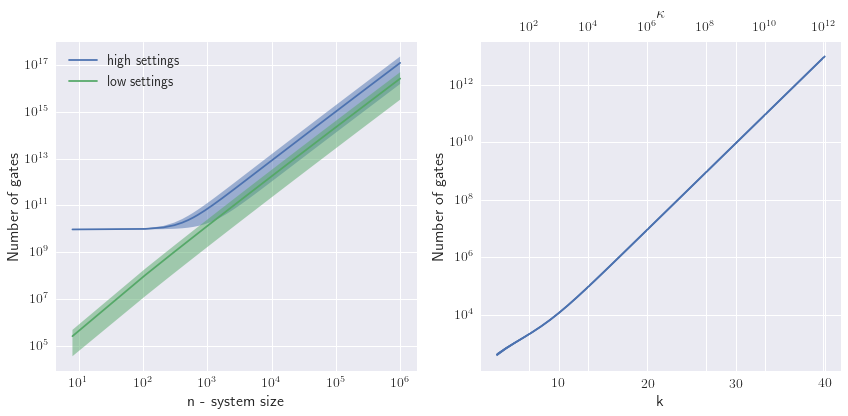

In [10]:
import matplotlib.pyplot as plt

def k2kappa(x):
    return 2**x


def kappa2k(x):
    return np.log2(x)

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

import matplotlib.style as style 
style.use('seaborn')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif',size=20)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)

fig = plt.figure(figsize = (12, 6))
ax0 = fig.add_subplot(121)
plt.grid(True)

xsn = np.arange(8,1e6, 100 )

params_mean = np.mean(m, axis = 0)

ax0.loglog(xsn, final_model([np.ones(xsn.shape)*30,np.ones(xsn.shape)*50, xsn ],  *params_mean), label = 'high settings')

plt.fill_between(xsn, final_model([np.ones(xsn.shape)*30,np.ones(xsn.shape)*50, xsn ],  *params_mean)
           -uncertainty_model([np.ones(xsn.shape)*30,np.ones(xsn.shape)*50, xsn ],  *params_mean, 
                                    dalphas = np.std(m, axis = 0)),
               final_model([np.ones(xsn.shape)*30,np.ones(xsn.shape)*50, xsn ],  *params_mean)
           +uncertainty_model([np.ones(xsn.shape)*30,np.ones(xsn.shape)*50, xsn ],  *params_mean, 
                                    dalphas = np.std(m, axis = 0))
               , alpha = 0.5)

ax0.loglog(xsn, final_model([np.ones(xsn.shape)*8,np.ones(xsn.shape)*40, xsn ],  *params_mean), label = 'low settings')

plt.fill_between(xsn, final_model([np.ones(xsn.shape)*8,np.ones(xsn.shape)*40, xsn ],  *params_mean)
           -uncertainty_model([np.ones(xsn.shape)*8,np.ones(xsn.shape)*40, xsn ],  *params_mean, 
                                    dalphas = np.std(m, axis = 0)),
               final_model([np.ones(xsn.shape)*8,np.ones(xsn.shape)*40, xsn ],  *params_mean)
           +uncertainty_model([np.ones(xsn.shape)*8,np.ones(xsn.shape)*40, xsn ],  *params_mean, 
                                    dalphas = np.std(m, axis = 0))
               , alpha = 0.5)

ax0.set_ylabel('Number of gates')
ax0.set_xlabel('n - system size')
#ax0.set_title('Total cost of QGP', y=1.15, size = 20)
ax0.legend()

ax1 = fig.add_subplot(122)
plt.grid(True)

ax2 = ax1.twiny()

k = np.linspace(3, 40, 38)
r = np.ones(xsn.shape)*50
X = [k, r, xsn]

x = k2kappa(k) 
y = overhead_model(X, *params_upper) 

ax1.semilogy(k, y)
ax1.set_xlabel('k')
ax1.set_ylabel('Number of gates')
#ax1.set_title('QGP cost overhead', y=1.15, size = 20)

ax2.loglog(x, y)
plt.fill_between(x, y - uncertainty_overhead(k,  *params_mean, dalphas = np.std(m, axis = 0))
                 ,y + uncertainty_overhead(k,  *params_mean, dalphas = np.std(m, axis = 0)) )

ax2.set_xscale('log')
ax2.set_xlabel(r'$\kappa$')

plt.tight_layout()
plt.show()

#fig.savefig('Figures/11_cost.pdf', inches = 'tight')

#### Plot as separate Figs

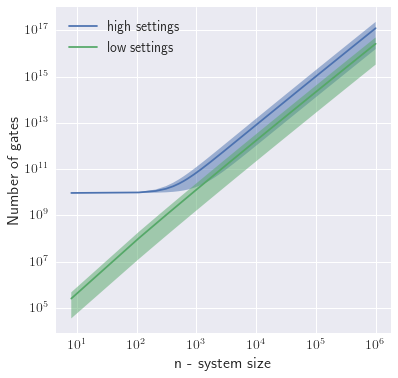

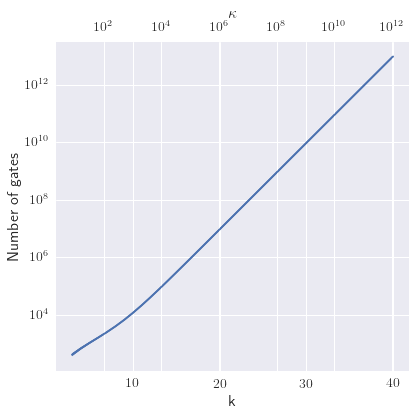

In [11]:
fig1 = plt.figure(figsize = (6, 6))
ax0 = fig1.add_subplot(111)
plt.grid(True)

xsn = np.arange(8,1e6, 100 )

params_mean = np.mean(m, axis = 0)

ax0.loglog(xsn, final_model([np.ones(xsn.shape)*30,np.ones(xsn.shape)*50, xsn ],  *params_mean), label = 'high settings')

plt.fill_between(xsn, final_model([np.ones(xsn.shape)*30,np.ones(xsn.shape)*50, xsn ],  *params_mean)
           -uncertainty_model([np.ones(xsn.shape)*30,np.ones(xsn.shape)*50, xsn ],  *params_mean, 
                                    dalphas = np.std(m, axis = 0)),
               final_model([np.ones(xsn.shape)*30,np.ones(xsn.shape)*50, xsn ],  *params_mean)
           +uncertainty_model([np.ones(xsn.shape)*30,np.ones(xsn.shape)*50, xsn ],  *params_mean, 
                                    dalphas = np.std(m, axis = 0))
               , alpha = 0.5)

ax0.loglog(xsn, final_model([np.ones(xsn.shape)*8,np.ones(xsn.shape)*40, xsn ],  *params_mean), label = 'low settings')

plt.fill_between(xsn, final_model([np.ones(xsn.shape)*8,np.ones(xsn.shape)*40, xsn ],  *params_mean)
           -uncertainty_model([np.ones(xsn.shape)*8,np.ones(xsn.shape)*40, xsn ],  *params_mean, 
                                    dalphas = np.std(m, axis = 0)),
               final_model([np.ones(xsn.shape)*8,np.ones(xsn.shape)*40, xsn ],  *params_mean)
           +uncertainty_model([np.ones(xsn.shape)*8,np.ones(xsn.shape)*40, xsn ],  *params_mean, 
                                    dalphas = np.std(m, axis = 0))
               , alpha = 0.5)

ax0.set_ylabel('Number of gates')
ax0.set_xlabel('n - system size')
#ax0.set_title('Total cost of QGP', y=1.15, size = 20)
ax0.legend()

fig2 = plt.figure(figsize = (6, 6))
ax1 = fig2.add_subplot(111)
plt.grid(True)

ax2 = ax1.twiny()

k = np.linspace(3, 40, 38)
r = np.ones(xsn.shape)*50
X = [k, r, xsn]

x = k2kappa(k) 
y = overhead_model(X, *params_upper) 

ax1.semilogy(k, y)
ax1.set_xlabel('k')
ax1.set_ylabel('Number of gates')
#ax1.set_title('QGP cost overhead', y=1.15, size = 20)

ax2.loglog(x, y)
plt.fill_between(x, y - uncertainty_overhead(k,  *params_mean, dalphas = np.std(m, axis = 0))
                 ,y + uncertainty_overhead(k,  *params_mean, dalphas = np.std(m, axis = 0)) )

ax2.set_xscale('log')
ax2.set_xlabel(r'$\kappa$')

plt.tight_layout()
plt.show()

fig1.savefig('Figures/11A_cost.pdf', inches = 'tight')
fig2.savefig('Figures/11B_cost.pdf', inches = 'tight')